원본 코드 및 doheon 님의 설명을 보고 싶으시다면 아래의 링크로 가주시면 됩니다.
- Original code: https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-3.lstm-post/

`결론`</br>
예측값이 올바르지 못하다. 트랜스포머 구조상 동적 디코딩을 통해 예측을 수행한다. 동적 디코딩은 예측값을 다음 step 예측을 위한 입력으로 사용하는데 이에 있어서 본 연습 코드의 예측하고자 하는 길이인 168은 해당 방식으로 예측하기에는 너무 길다고 할 수 있다. 따라서 충분한 학습을 수행한 뒤에만 적용할 수 있다. 입력 길이인 336은 충분하다고 할 수 없고, 그에 따라 예측 값의 정확도 또한 매우 좋지 못하다.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

C:\Users\RohSeungChan\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\RohSeungChan\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


,Unnamed: 0,집계일시,평균속도
0,0,2021050100,98.63
1,1,2021050101,100.53
2,2,2021050102,99.86
3,3,2021050103,99.34
4,4,2021050104,93.64


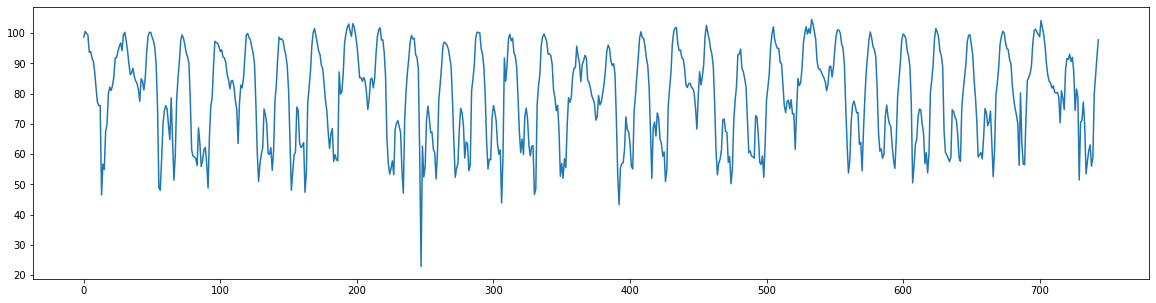

In [2]:
rawdata = pd.read_csv("서인천IC-부평IC 평균속도.csv", encoding='CP949')
plt.figure(figsize=(20,5))
plt.plot(range(len(rawdata)), rawdata["평균속도"])
rawdata.head()

In [3]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
rawdata["평균속도"] = min_max_scaler.fit_transform(rawdata["평균속도"].to_numpy().reshape(-1,1))


In [4]:
train = rawdata[:-24*7]
data_train = train["평균속도"].to_numpy()

test = rawdata[-24*7:]
data_test = test["평균속도"].to_numpy()

In [5]:
import torch
import torch.nn as nn
import numpy as np
import math
device = torch.device("cuda")

# Transformer Encoder, Decoder

In [6]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        # 3가지 아이템을 반환함
            # a = [1,2,3,4,5]
            # a[:-1] = [1,2,3,4]
            # a[1:] = [2,3,4,5]
        return self.x[i], self.y[i, :-1], self.y[i,1:]
    def __len__(self):
        return self.len

In [7]:
iw = 24*14
ow = 24*7

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

In [8]:
from torch.nn import Transformer
from torch import nn
import torch
import math

class TFModel(nn.Module):
    def __init__(self,d_model, nhead, nhid, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.transformer = Transformer(d_model=d_model, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers,dropout=dropout)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_encoder_d = PositionalEncoding(d_model, dropout)
        self.linear = nn.Linear(d_model, 1)
        self.encoder = nn.Linear(1, d_model) ## 인코더의 임베딩 Linear
        self.encoder_d = nn.Linear(1, d_model) ## 디코더의 임베딩 Linear

    def generate_square_subsequent_mask(self, sz):
        # 하삼각행렬 부분만 남기는 부분
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        # True와 False로 되어있는 것을 float으로 바꾸고 이후에 0은 '-inf'로 1은 0.0으로 바꾸기
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, srcmask, tgtmask):
        ## 인코더 임베딩과 positional encoding을 둘 다 하여 더해준다.
        src = self.encoder(src) # 인코더의 임베딩 레이어
        src = self.pos_encoder(src) # 인코더의 positional 인코딩 레이어

        tgt = self.encoder_d(tgt) # 디코더의 임베딩 레이어
        tgt = self.pos_encoder_d(tgt) # 디코더의 positional 인코딩 레이어
        output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), srcmask, tgtmask) # 트랜스포머 입력으로는 (인코더의 입력값, 디코더 입력값, 인코더 마스크 행렬, 디코더 마스크 행렬)이 있다.
        output = self.linear(output) # 최종 linear
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x) # 임베딩 값과 positional encoding 값 더하기

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

----

## 모델 뜯어보기

In [46]:
"""mini-batch 하나만 가져오기"""
## Train 시의 모델 입력값
for (inputs, dec_inputs, outputs) in train_loader:
    first_inputs = inputs
    first_dec_inputs = dec_inputs
    first_outputs = outputs
    break

## 첫 번째 모델 입력값
print('인코더 입력값 :', first_inputs.shape) # [[1],[2],[3],[4],[5]], [[2],[3],[4],[5],[6]]]
print('디코더 입력값 :', first_dec_inputs.shape) # [[6], [7]]
print('출력값 :', first_outputs.shape) # [[7], [8]]

인코더 입력값 : torch.Size([64, 336, 1])
디코더 입력값 : torch.Size([64, 167, 1])
출력값 : torch.Size([64, 167, 1])


In [39]:
# 첫 번째 batch의 디코더 입력값들로 값이 하나씩 이루어져 있는 것을 알 수 있다.
first_dec_inputs[0,:,:].shape

torch.Size([167, 1])

In [22]:
"""마스킹 설정: generate_square_subsequent_mask()"""
# 하삼각행렬 부분만 남기는 부분
    # 하삼각행렬 성분들은 모두 True로 만들고 나머지는 False
src_mask = (torch.triu(torch.ones(first_inputs.shape[1], first_inputs.shape[1])) == 1).transpose(0, 1).to(device)
tgt_mask = (torch.triu(torch.ones(first_dec_inputs.shape[1], first_dec_inputs.shape[1])) == 1).transpose(0, 1).to(device)
print('인코더의 input masking:', src_mask.shape)
print('디코더의 input masking:', tgt_mask.shape)

# 예시
src_mask

인코더의 input masking: torch.Size([336, 336])
디코더의 input masking: torch.Size([167, 167])


tensor([[ True, False, False,  ..., False, False, False],
        [ True,  True, False,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ...,  True, False, False],
        [ True,  True,  True,  ...,  True,  True, False],
        [ True,  True,  True,  ...,  True,  True,  True]], device='cuda:0')

In [23]:
# 대각성분 위의 애들(0인 애들)은 모두 -inf로 설정
# 대각성분 아래의 애들(1인 애들)은 모두 0.0으로 설정
src_mask = src_mask.float().masked_fill(src_mask == 0, float('-inf')).masked_fill(src_mask == 1, float(0.0))
tgt_mask = tgt_mask.float().masked_fill(tgt_mask == 0, float('-inf')).masked_fill(tgt_mask == 1, float(0.0))
print(src_mask.shape)
print(tgt_mask.shape)
print(src_mask)
print(tgt_mask)

torch.Size([336, 336])
torch.Size([167, 167])
tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


In [24]:
"""
## model에 입력되는 5가지 값
- d_model, nhead, nhid, nlayers, dropout=0.5

## forward 함수에 입력되는 4가지 값
- 인코더 입력값, 디코더 입력값, 소스 시퀀스 마스킹, 디코더 시퀀스 마스킹
"""
first_inputs = first_inputs.float().to(device) # 인코더 입력값
dec_inputs = dec_inputs.float().to(device) # 디코더 입력값
# src_mask
# tgt_mask

In [25]:
"""트랜스포머의 forward 함수 진행 부분"""
d_model = 256
dropout = 0.5

self_pos_encoder = PositionalEncoding(d_model, dropout).to(device) # 인코더의 positional 인코딩 레이어
self_pos_encoder_d = PositionalEncoding(d_model, dropout).to(device) # 디코더의 positional 인코딩 레이어
self_encoder = nn.Linear(1, d_model).to(device) ## 인코더의 임베딩 Linear
self_encoder_d = nn.Linear(1, d_model).to(device) ## 디코더의 임베딩 Linear

## 인풋 데이터인 1차원의 벡터를 d_model의 차원으로 linear layer를 통해 바꿔준 후 positional encoding을 거쳐서 transformer를 통과
    # 입력 시퀀스에 대한 임베딩과 positional encoding
src = self_encoder(first_inputs)
src = self_pos_encoder(src)

tgt = self_encoder_d(dec_inputs)
tgt = self_pos_encoder_d(tgt)

In [26]:
"""Positional Encoding 함수"""
max_len = 5000
d_model = 256
pe = torch.zeros(max_len, d_model)
print('positional encoding shape:', pe.shape)

position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1) # 0부터 최대 길이까지 arange로 정렬
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)
print('positional encoding shape:', pe.shape)

pe = pe.unsqueeze(0).transpose(0, 1)
print('positional encoding shape:', pe.shape)

self_pe = pe
pos_inputs = src.clone().to(device)
# pos_inputs = Positional Encoding 함수의 입력값=> 요소별 덧셈 진행
pos_inputs = pos_inputs + self_pe[:pos_inputs.size(0), :].to(device)
print(' # positional encoding을 거친 최종 output shape: ', pos_inputs.shape) # [batch_size, input_length, embedding_features]

positional encoding shape: torch.Size([5000, 256])
positional encoding shape: torch.Size([5000, 256])
positional encoding shape: torch.Size([5000, 1, 256])
 # positional encoding을 거친 최종 output shape:  torch.Size([64, 336, 256])


In [27]:
print(src.transpose(0, 1).shape) # [encoder_input_length, batch_size, embedding_features]
print(tgt.transpose(0, 1).shape) # [decoder_input_length, batch_size, embedding_features]
print('input mask shape: ',src_mask.shape) # [decoder_input_length, decoder_input_length]
print('decoder input mask shape: ',tgt_mask.shape) # [encoder_input_length, encoder_input_length]

torch.Size([336, 64, 256])
torch.Size([167, 64, 256])
input mask shape:  torch.Size([336, 336])
decoder input mask shape:  torch.Size([167, 167])


In [28]:
d_model = 256
nhead = 8
nhid = 256
nlayers = 2
dropout = 0.1

self_transformer = nn.Transformer(d_model, nhead = nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers, dropout=dropout ).to(device)
output = self_transformer(src.transpose(0, 1), tgt.transpose(0, 1), src_mask, tgt_mask)
print('# 트랜스포머 output shape:', output.shape) # [decoder_input_length, batch_size, embedding_features]

# 트랜스포머 output shape: torch.Size([167, 64, 256])


In [30]:
self_linear = nn.Linear(d_model, 1).to(device)
final_output = self_linear(output)
print('# 최종 출력값:', final_output.shape) # [decoder_output_length, batch_size, out_features] # 임베딩 feature가 기존의 feature 개수로 맞춰짐

# 최종 출력값: torch.Size([167, 64, 1])


----

## 모델 실행 부분

In [9]:
device = torch.device("cuda")

lr = 1e-3
# d_model, nhead, nhid, nlayers, dropout=0.5
model = TFModel(d_model=256, nhead=8, nhid=256, nlayers=2, dropout=0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
epoch = 2000
from tqdm import tqdm

model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    
    for (inputs, dec_inputs, outputs) in train_loader:
        optimizer.zero_grad()

        # 마스킹 함수 적용
            # 하삼각행렬만 살려놓음
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)

        result = model(inputs.float().to(device), dec_inputs.float().to(device), src_mask, tgt_mask)
        loss = criterion(result.permute(1,0,2), outputs.float().to(device))
        
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_loader)))

0.05088:   1%|          | 15/2000 [00:03<07:07,  4.65it/s]


KeyboardInterrupt: 

In [16]:
def evaluate(length):
    input = torch.tensor(data_train[-24*7*2:]).reshape(1,-1,1).to(device).float().to(device)
    output = torch.tensor(data_train[-1].reshape(1,-1,1)).float().to(device) # 평가 시의 디코더 첫 번째 값은 인코더의 마지막 값과 같은 값이 들어감
    model.eval()
    for i in range(length):
        src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device) # 인코더의 input 마스킹
        tgt_mask = model.generate_square_subsequent_mask(output.shape[1]).to(device) # 디코더의 input 마스킹

        predictions = model(input, output, src_mask, tgt_mask).transpose(0,1)
        predictions = predictions[:, -1:, :]
        # predictions = predictions[:, -1:, :]은 하나의 값임
        print('prediction length:', predictions.shape)
        print('output length:', output.shape)
        print()
        output = torch.cat([output, predictions.to(device)], axis=1) # [1, 1, 1] -> [1, 2, 1] -> [1, 4, 1] -> [1, 8, 1] 식으로 concat 됨
    return torch.squeeze(output, axis=0).detach().cpu().numpy()[1:]

In [11]:
model.load_state_dict(torch.load("one_step_Transformer.pth"))

<All keys matched successfully>

----

## 1 step 예측에 있어서 output의 형태 확인
- 동적 방식인지 확인

In [15]:
## 1 step 예측 첫 입력값
eval_input = torch.tensor(data_train[-24*7*2:]).reshape(1,-1,1).to(device).float().to(device) # 검증 부분만 뽑기
eval_output = torch.tensor(data_train[-1].reshape(1,-1,1)).float().to(device) # 

In [62]:
print('평가 입력 shape: ', eval_input.shape)
print('평가 출력 shape: ', eval_output.shape)

평가 입력 shape:  torch.Size([1, 336, 1])
평가 출력 shape:  torch.Size([1, 1, 1])


----

In [17]:
result = evaluate(24*7)
result = min_max_scaler.inverse_transform(result)
real = rawdata["평균속도"].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))

prediction length: torch.Size([1, 1, 1])
output length: torch.Size([1, 1, 1])

prediction length: torch.Size([1, 1, 1])
output length: torch.Size([1, 2, 1])

prediction length: torch.Size([1, 1, 1])
output length: torch.Size([1, 3, 1])

prediction length: torch.Size([1, 1, 1])
output length: torch.Size([1, 4, 1])

prediction length: torch.Size([1, 1, 1])
output length: torch.Size([1, 5, 1])

prediction length: torch.Size([1, 1, 1])
output length: torch.Size([1, 6, 1])

prediction length: torch.Size([1, 1, 1])
output length: torch.Size([1, 7, 1])

prediction length: torch.Size([1, 1, 1])
output length: torch.Size([1, 8, 1])

prediction length: torch.Size([1, 1, 1])
output length: torch.Size([1, 9, 1])

prediction length: torch.Size([1, 1, 1])
output length: torch.Size([1, 10, 1])

prediction length: torch.Size([1, 1, 1])
output length: torch.Size([1, 11, 1])

prediction length: torch.Size([1, 1, 1])
output length: torch.Size([1, 12, 1])

prediction length: torch.Size([1, 1, 1])
output l

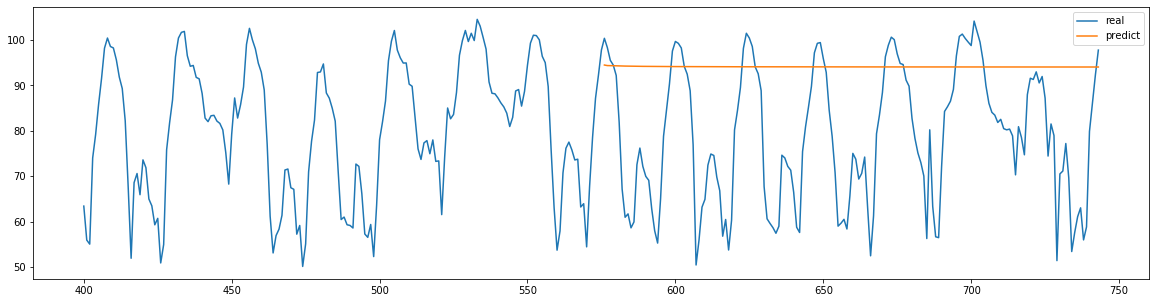

In [18]:
## 긴 길이를 예측하는 데에 있어서 충분한 학습을 하지 못함
plt.figure(figsize=(20,5))
plt.plot(range(400,744),real[400:], label="real")
plt.plot(range(744-24*7,744),result, label="predict")
plt.legend()
plt.show()

In [19]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPEval(result, real[-24*7:])

25.88340174752237

In [15]:
torch.save(model.state_dict(), "one_step_Transformer.pth")